In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import numpy as np

ModuleNotFoundError: No module named 'yfinance'

In [2]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
# px를 쉽고 빠르게 붙여주는 모듈 cufflinks
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')

import plotly.graph_objects as go

import matplotlib.pyplot as plt

import datetime as dt

In [3]:
%run ../library/QUANT_FUNCTIONS.ipynb
Q = QUANT()
D = DATA()

In [4]:
## 조건1. 판단기간 -> 1개월, 3개월, 6개월 평균
## 조건2. 양자산 모두 조건1에서 무위험 이하 -> 미 장기채

###### 공통함수

In [5]:
## 수치형 데이터프레임을 시작점기준으로 지수화
def index_values(df):
    for i in df.columns:
        if (df[i].dtype == float)|(df[i].dtype == int):
            df[i] = df[i]/df[i][0]
        else:
            df[i] = df[i]
    return df

## 듀얼전략

### 데이터 구성 함수

In [6]:
## 데이터 불러오기
def get_dual_df(first_ticker, second_ticker, safe_ticker):
    ## 주투자자산, 보조투자자산, 안전자산
    first = yf.Ticker(first_ticker)
    second= yf.Ticker(second_ticker)
    safe = yf.Ticker(safe_ticker)

    first_df = first.history(period="max")
    second_df = second.history(period="max")
    safe_df = safe.history(period="max")
    
    df = pd.concat([first_df['Close'], second_df['Close'], safe_df['Close']], axis = 1)
    df.columns = [first_ticker, second_ticker, safe_ticker]
    df = df.dropna()
    
    return df

### 듀얼전략 구현

In [7]:
### 1개월 수익률, 3개월 수익률, 6개월 수익률의 평균 산출함수
def get_mpr(close):
    ## get_signal()로 이어짐
    df_cls = close
    pr1 = np.log(df_cls/df_cls.shift(20))
    pr3 = np.log(df_cls/df_cls.shift(60))
    pr6 = np.log(df_cls/df_cls.shift(120))
    df_pr = pd.concat([pr1, pr3, pr6], axis = 1)
    mpr = df_pr.mean(axis=1)
    return mpr

def get_signal(df):
    ## 금리2% 1개월 무위험수익률 ## 향후 기준금리 데이터 반영 가능
    ## get_strategy_value()로 이어짐
    nrr = 1.02**(1/12)
    ## 1개월 3개월 6개월 무위험수익률 평균
    thr = np.mean([nrr-1, (nrr**3)-1, (nrr**6)-1])
    
    first_ticker = df.columns[0]
    second_ticker = df.columns[1]
    safe_ticker = df.columns[2]
    
    first_df = get_mpr(df[first_ticker])
    second_df = get_mpr(df[second_ticker])
    safe_df = get_mpr(df[safe_ticker])
    
    signal_df = pd.concat([first_df, second_df, safe_df], axis=1)
    signal_df.columns = [first_ticker, second_ticker, safe_ticker]
    signal_df = signal_df.dropna()
    ## 판단로직
    signal_df['signal'] = safe_ticker
    signal_df['signal'][(signal_df[first_ticker] > thr)|(signal_df[second_ticker] > thr)] = second_ticker
    signal_df['signal'][(signal_df['signal'] ==second_ticker)&(signal_df[first_ticker] >= signal_df[second_ticker])] = first_ticker
    
    new_df = df.copy()
    new_df['signal'] = signal_df['signal']
    new_df['prev'] = new_df['signal'].shift(1)
    
    new_df['change'] = 0
    new_df['change'][new_df['signal'] != new_df['prev']] = 1
    new_df = new_df.dropna()
    return new_df

def get_strategy_value(df):
    new_df = get_signal(df)
    ## 시그널발생시 자산 교환 비율 산출
    new_df['exchange_rate'] = 1.0
    for i in range(len(new_df)):
        if (new_df['change'][i] == 1)&(type(new_df['prev'][i]) == str):
            new_df['exchange_rate'][i] = new_df[new_df['prev'][i]][i]/new_df[new_df['signal'][i]][i]         
    ## 누적 교환비 산출
    new_df['cum_exchange_rate'] = new_df['exchange_rate']
    for i in range(len(new_df)):
        new_df['cum_exchange_rate'][i] = new_df['exchange_rate'][:i+1].product()
    ## 자산추이
    new_df['strategy'] = 1.0
    for i in range(len(new_df)):
        new_df['strategy'][i] = new_df[new_df['signal'][i]][i]*new_df['cum_exchange_rate'][i]

    first_ticker = df.columns[0]
    second_ticker = df.columns[1]
    safe_ticker = df.columns[2]
    
    result = new_df[[first_ticker, second_ticker, safe_ticker, 'strategy', 'signal']]
    return result

## 올웨더 전략

### 데이터 불러오기

In [8]:
## 데이터 불러오기
def get_AWP_df(first_ticker, second_ticker, fixed_ticker, gold_ticker, etc_ticker):
    ## 주투자자산, 보조투자자산, 안전자산
    first = yf.Ticker(first_ticker)
    second= yf.Ticker(second_ticker)
    fixed = yf.Ticker(fixed_ticker)
    gold = yf.Ticker(gold_ticker)
    etc = yf.Ticker(etc_ticker)

    first_df = first.history(period="max")
    second_df = second.history(period="max")
    fixed_df = fixed.history(period="max")
    gold_df = gold.history(period="max")
    etc_df = etc.history(period="max")
    
    df = pd.concat([first_df['Close'], second_df['Close'], fixed_df['Close'], gold_df['Close'], etc_df['Close']], axis = 1)
    df.columns = [first_ticker, second_ticker, fixed_ticker, gold_ticker, etc_ticker]
    df = df.dropna()
    
    return df

### AWP전략 구현

In [9]:
def cal_AWP(df, ratio = [0.5, 0.5], rebalancing=None, unit = None):
    new_df = df.copy()
    ## rebalancing 'm'월, 'y'연, 
    df_dict = []
    ## 데이터 분할
    years = sorted(new_df.index.year.unique())
    months = sorted(new_df.index.month.unique())
    
    ## 가치변화 계산용(월단위 집계데이터로 계산할 때 발생하는 에러보정)
    if (rebalancing == 'm')&(unit == 'monthly'):
        temp_df = new_df.copy()
        temp_df.index = temp_df.index - dt.timedelta(days=1)
        new_df = new_df.append(temp_df)
        new_df = new_df.sort_index()
        new_df = new_df.shift(-1).dropna()
        
    if rebalancing == 'm' :
        for year in years:
            for month in months:
                temp = new_df[(new_df.index.year == year)&(new_df.index.month == month)]
                if len(temp) > 0:
                    df_dict.append(temp)
                    
    elif rebalancing == 'y':
        for year in years:
            temp = new_df[(new_df.index.year == year)]
            if len(temp) > 0:
                df_dict.append(temp)
    else:
        df_dict.append(new_df)
    ## 리벨런싱 적용
    prev_val = 1
    temp_series = pd.Series()
    for i in range(len(df_dict)):    
        temp = index_values(df_dict[i])
        temp_AWP = (temp * ratio).sum(axis=1)*prev_val
        prev_val = temp_AWP[-1]
        temp_series = temp_series.append(temp_AWP)
    new_df['strategy'] = temp_series
    
    ## 가치변화 계산용 임시 데이터프레임을 원래 형태로 되돌림
    if (rebalancing == 'm')&(unit == 'monthly'):
        new_df['temp_y'] = new_df.index.year
        new_df['temp_m'] = new_df.index.month
        new_df = new_df.drop_duplicates(['temp_y', 'temp_m'])
        new_df = new_df.drop(columns=['temp_y', 'temp_m'])
        new_df.index = df.index
    
    return new_df

## 최적화

In [12]:
def cal_optimal(df, df_unit='monthly', rebalancing = 'm'):
    ## df_unit 데이터 집계주기 : daily, monthly => 수익, 위험 연율화 계산에 사용
    ## rebalancing 리벨런싱 주기 : None, m, y
    pyrr = []     # 리스트 형태로 수익을 쌓을 장소
    pydd = []     # 리스트 형태로 위험(표준편차)을 쌓을 장소
    pstn = []
    weghs = []

    for p in range (10000):
        if p%10 == 0:
            print(f"{p}단계 진행중")
        weights = np.random.random(len(df.T))   # 랜덤한 n개의 숫자를 생성함(n개의 자산에 대응)
        weights /= np.sum(weights)     # n개의 숫자의 합계가 1이 되도록 조정함(각 자산의 비중)

        result_df = cal_AWP(df, weights, rebalancing=rebalancing, unit=df_unit)
        sortino = Q.get_SRTR_report(result_df, 'a', unit=df_unit)

        pyrr.append(sortino['YRR'][len(sortino)-1])
        pydd.append(sortino['YDD'][len(sortino)-1])
        pstn.append(sortino['Sortino Ratio'][len(sortino)-1])
        weghs.append(weights)

    pyrr = np.array(pyrr)
    pydd = np.array(pydd)
    pstn = np.array(pstn)
    weghs = np.array(weghs)

    process = pd.DataFrame(weghs, columns=df.columns)
    process['YRR'] = pyrr
    process['YDD'] = pydd
    process['Sortino Ratio'] = pstn
    
    obtimal = process[process['Sortino Ratio']==process['Sortino Ratio'].max()]
    obtimal = obtimal.reset_index(drop=True)
    min_risk = process[process['YDD']==process['YDD'].min()]
    min_risk = min_risk.reset_index(drop=True)

    return process, obtimal, min_risk

## 활용

In [11]:
## 올웨더 최적화 ## TQQQ;*3 TYD;7~10,*3 ## TMF;20+,*3 ## IAU;금,*1 ## DBC;원자재*1
AWP_df = D.get_merged_df('SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'IAU', 'DBC')
AWP_df = AWP_df.dropna()
## 백데이터 기간정의(10년 2600일)
## AWP_df = AWP_df.iloc[-2515:]

In [13]:
## trainset = AWP_df[AWP_df.index >= '2020-01-01']
trainset = AWP_df.copy()
process, obtimal, min_risk = cal_optimal(trainset, df_unit='daily', rebalancing = 'd')

0단계 진행중
10단계 진행중
20단계 진행중
30단계 진행중
40단계 진행중
50단계 진행중
60단계 진행중
70단계 진행중
80단계 진행중
90단계 진행중
100단계 진행중
110단계 진행중
120단계 진행중
130단계 진행중
140단계 진행중
150단계 진행중
160단계 진행중
170단계 진행중
180단계 진행중
190단계 진행중
200단계 진행중
210단계 진행중
220단계 진행중
230단계 진행중
240단계 진행중
250단계 진행중
260단계 진행중
270단계 진행중
280단계 진행중
290단계 진행중
300단계 진행중
310단계 진행중
320단계 진행중
330단계 진행중
340단계 진행중
350단계 진행중
360단계 진행중
370단계 진행중
380단계 진행중
390단계 진행중
400단계 진행중
410단계 진행중
420단계 진행중
430단계 진행중
440단계 진행중
450단계 진행중
460단계 진행중
470단계 진행중
480단계 진행중
490단계 진행중
500단계 진행중
510단계 진행중
520단계 진행중
530단계 진행중
540단계 진행중
550단계 진행중
560단계 진행중
570단계 진행중
580단계 진행중
590단계 진행중
600단계 진행중
610단계 진행중
620단계 진행중
630단계 진행중
640단계 진행중
650단계 진행중
660단계 진행중
670단계 진행중
680단계 진행중
690단계 진행중
700단계 진행중
710단계 진행중
720단계 진행중
730단계 진행중
740단계 진행중
750단계 진행중
760단계 진행중
770단계 진행중
780단계 진행중
790단계 진행중
800단계 진행중
810단계 진행중
820단계 진행중
830단계 진행중
840단계 진행중
850단계 진행중
860단계 진행중
870단계 진행중
880단계 진행중
890단계 진행중
900단계 진행중
910단계 진행중
920단계 진행중
930단계 진행중
940단계 진행중
950단계 진행중
960단계 진행중
970단계 진행중
980단계 진행중
990단계 진행중
1000단계 진행중


7550단계 진행중
7560단계 진행중
7570단계 진행중
7580단계 진행중
7590단계 진행중
7600단계 진행중
7610단계 진행중
7620단계 진행중
7630단계 진행중
7640단계 진행중
7650단계 진행중
7660단계 진행중
7670단계 진행중
7680단계 진행중
7690단계 진행중
7700단계 진행중
7710단계 진행중
7720단계 진행중
7730단계 진행중
7740단계 진행중
7750단계 진행중
7760단계 진행중
7770단계 진행중
7780단계 진행중
7790단계 진행중
7800단계 진행중
7810단계 진행중
7820단계 진행중
7830단계 진행중
7840단계 진행중
7850단계 진행중
7860단계 진행중
7870단계 진행중
7880단계 진행중
7890단계 진행중
7900단계 진행중
7910단계 진행중
7920단계 진행중
7930단계 진행중
7940단계 진행중
7950단계 진행중
7960단계 진행중
7970단계 진행중
7980단계 진행중
7990단계 진행중
8000단계 진행중
8010단계 진행중
8020단계 진행중
8030단계 진행중
8040단계 진행중
8050단계 진행중
8060단계 진행중
8070단계 진행중
8080단계 진행중
8090단계 진행중
8100단계 진행중
8110단계 진행중
8120단계 진행중
8130단계 진행중
8140단계 진행중
8150단계 진행중
8160단계 진행중
8170단계 진행중
8180단계 진행중
8190단계 진행중
8200단계 진행중
8210단계 진행중
8220단계 진행중
8230단계 진행중
8240단계 진행중
8250단계 진행중
8260단계 진행중
8270단계 진행중
8280단계 진행중
8290단계 진행중
8300단계 진행중
8310단계 진행중
8320단계 진행중
8330단계 진행중
8340단계 진행중
8350단계 진행중
8360단계 진행중
8370단계 진행중
8380단계 진행중
8390단계 진행중
8400단계 진행중
8410단계 진행중
8420단계 진행중
8430단계 진행중
8440단계 진행중
8450단계 진행중

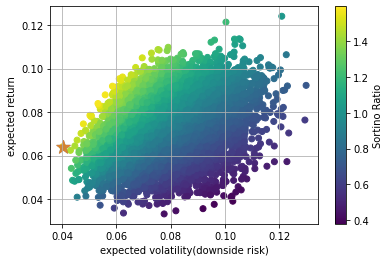

In [14]:
plt.scatter(process['YDD'], process['YRR'], c=process['Sortino Ratio'], marker='o')
plt.grid(True)
plt.xlabel('expected volatility(downside risk)')
plt.ylabel('expected return')
plt.colorbar(label='Sortino Ratio')

plt.scatter(obtimal['YDD'][0], obtimal['YRR'][0], marker="*", s=200, alpha=0.7)
plt.scatter(min_risk['YDD'][0], min_risk['YRR'][0], marker="*", s=200, alpha=0.7)

plt.show()

In [71]:
## ('UPRO', 'TQQQ', 'EURL', 'EDC', 'TMF', 'TYD', 'SHY', 'IAU', 'DBC')
## [0.24, 0.03, 0.01, 0.04, 0.20, 0.09, 0.09 , 0.24, 0.06]

In [65]:
test = process[process['YRR']>=0.08]

In [74]:
obtimal = test[test['Sortino Ratio'] == test['Sortino Ratio'].max()]

In [75]:
AWP_ratio = pd.DataFrame(list(obtimal.values[0][:-3]),
             index=['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'IAU', 'DBC'], columns=['ratio'])
AWP_ratio = AWP_ratio.apply(lambda x:x.round(2))

In [76]:
AWP_ratio

,ratio
SPY,0.23
QQQ,0.10
VEA,0.02
VWO,0.01
TLT,0.16
IEF,0.25
SHY,0.16
IAU,0.06
DBC,0.01


In [89]:
## 올웨더 전략 실행
ratio = list(obtimal.values[0][:-3])
ratio = [0.25, 0.2, 0.02, 0.02, 0.15, 0.15, 0.15, 0.05, 0.01]
AWP_result = cal_AWP(AWP_df, ratio=ratio, rebalancing='m')
## 듀올 전략 실행
## dual_df = get_dual_df('TQQQ', 'UPRO', 'TMF')
## dual_df_result = get_strategy_value(dual_df)

In [70]:
'''## 수정 AWP
TAWP_df = D.get_merged_df('UPRO', 'TQQQ', 'TMF', 'TYD')
TAWP_df = TAWP_df.dropna()
AWP_result = cal_AWP(TAWP_df, ratio=[0.25, 0.25, 0.25, 0.25], rebalancing='m')
## 듀올 전략 실행
## dual_df = get_dual_df('TQQQ', 'UPRO', 'TMF')
## dual_df_result = get_strategy_value(dual_df)'''

"## 수정 AWP\nTAWP_df = D.get_merged_df('UPRO', 'TQQQ', 'TMF', 'TYD')\nTAWP_df = TAWP_df.dropna()\nAWP_result = cal_AWP(TAWP_df, ratio=[0.25, 0.25, 0.25, 0.25], rebalancing='m')\n## 듀올 전략 실행\n## dual_df = get_dual_df('TQQQ', 'UPRO', 'TMF')\n## dual_df_result = get_strategy_value(dual_df)"

In [90]:
## 결과 통합
result_df = AWP_result.copy()
## result_df['Dual'] = dual_df_result['strategy']
## result_df['signal'] = dual_df_result['signal']

result_df = result_df.dropna()

## 표준화
result_df = index_values(result_df)

In [97]:
AWP_ratio.to_csv('result/AWP_ratio_2021.csv')

In [76]:
result_df.to_csv('result/AWP_result_d.csv')

###### 보고서

In [93]:
## 월단위 리벨런싱
result_df['year'] = result_df.index.year
result_df['month'] = result_df.index.month

result_df = result_df.drop_duplicates(['year', 'month'], keep='last')
result_df = result_df.drop(columns=['year', 'month'])

In [94]:
# 시각화 관련
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
result_df

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY,IAU,DBC,strategy
Date,,,,,,,,,,
2007-07-31,0.984462,0.970396,1.000000,1.012644,1.007239,1.003522,1.001492,1.003655,1.006147,0.992530
2007-08-31,0.997095,0.997754,0.999165,1.012537,1.025245,1.026234,1.011996,1.014771,0.986938,1.007554
2007-09-28,1.035697,1.050158,1.046765,1.112088,1.027584,1.027139,1.017581,1.121212,1.079908,1.031251
2007-10-31,1.049748,1.124104,1.093111,1.256751,1.046247,1.038201,1.022444,1.196894,1.171725,1.054551
2007-11-30,1.009088,1.048115,1.051984,1.149593,1.102234,1.080223,1.040775,1.179991,1.164425,1.051898
...,...,...,...,...,...,...,...,...,...,...
2021-08-31,4.043367,8.776339,1.666668,1.620661,2.593538,1.979339,1.283002,2.629054,0.789418,2.966694
2021-09-30,3.854924,8.277566,1.610242,1.566175,2.518144,1.947728,1.281708,2.543780,0.830576,2.867354
2021-10-29,4.125399,8.928514,1.662226,1.586531,2.580217,1.939101,1.277408,2.583371,0.878732,2.957089


In [96]:
Q.get_YTD_report(result_df, 'a')

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY,IAU,DBC,strategy
Date,,,,,,,,,,
2008,-0.367950,-0.417271,-0.406232,-0.524593,0.339518,0.179175,0.066225,0.051061,-0.317992,-0.127593
2009,0.263518,0.546841,0.275073,0.763109,-0.218063,-0.065932,0.003527,0.238980,0.161869,0.137288
2010,0.150561,0.201438,0.083544,0.194813,0.090126,0.093598,0.022796,0.294589,0.119009,0.086457
2011,0.018950,0.034758,-0.123146,-0.187510,0.340012,0.156497,0.014405,0.095683,-0.025771,0.100170
2012,0.159904,0.181125,0.185605,0.192104,0.024095,0.036640,0.002502,0.068943,0.035022,0.081758
2013,0.323078,0.366342,0.218065,-0.049415,-0.133814,-0.060902,0.002147,-0.282555,-0.076314,0.076332
2014,0.134638,0.191814,-0.059674,-0.000417,0.273019,0.090682,0.004470,-0.020548,-0.280982,0.137655
2015,0.012343,0.094359,-0.003732,-0.158195,-0.017896,0.015078,0.004298,-0.105769,-0.275881,0.004867
2016,0.119979,0.070979,0.026340,0.121711,0.011716,0.010016,0.008227,0.083089,0.185629,0.058907


In [97]:
MDD, HRR = Q.get_MDD_report(result_df, 'a')
MDD

,Ticker,MDD,Date
0,SPY,-0.507848,2009-02-27
1,QQQ,-0.497398,2009-02-27
2,VEA,-0.570527,2009-02-27
3,VWO,-0.616940,2009-02-27
4,TLT,-0.218063,2009-12-31
5,IEF,-0.076037,2013-12-31
6,SHY,-0.011807,2008-05-30
7,IAU,-0.425926,2015-12-31
8,DBC,-0.745525,2020-04-30
9,strategy,-0.222927,2009-02-27


In [99]:
Q.get_SRTR_report(result_df, 'a', unit='monthly')

,Ticker,YRR,YDD,Sortino Ratio
0,SPY,0.105518,0.103553,1.018976
1,QQQ,0.167109,0.112546,1.484798
2,VEA,0.034525,0.129210,0.267197
3,VWO,0.029619,0.151472,0.195539
4,TLT,0.068344,0.077732,0.879231
5,IEF,0.047231,0.034199,1.381064
6,SHY,0.016743,0.004694,3.566850
7,IAU,0.068239,0.110531,0.617373
8,DBC,-0.011901,0.149045,-0.079846
9,strategy,0.079514,0.050506,1.574344


In [25]:
result_df.to_csv('result/AWP_result.csv')

In [45]:
result_df[['strategy', 'SPY']].iplot()